In [7]:

!pip install qiskit qiskit-machine-learning tensorflow pandas scikit-learn matplotlib openpyxl
!pip install qiskit-algorithms

!pip install qiskit-ibm-runtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.9/359.9 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: qiskit
    Found existing installation: qiskit 1.4.0
    Uninstalling qiskit-1.4.0:
      Successfully uninstalled qiskit-1.4.0


In [2]:
!pip install qiskit==1.4.0

  Using cached qiskit-1.4.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached qiskit-1.4.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.7 MB)
  Attempting uninstall: qiskit
    Found existing installation: qiskit 2.0.0
    Uninstalling qiskit-2.0.0:
      Successfully uninstalled qiskit-2.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-ibm-runtime 0.39.0 requires qiskit>=1.4.1, but you have qiskit 1.4.0 which is incompatible.


In [3]:
!pip show qiskit






Name: qiskit
Version: 1.4.0
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-algorithms, qiskit-ibm-runtime, qiskit-machine-learning


In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import StatevectorSampler
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA,SPSA




In [48]:

df = pd.read_csv("/content/enp0s3-pvt-wednesday.pcap_Flow.csv")
# print(df.head())





In [49]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# print(df.head(2))

In [50]:
#check data types and missing values
print("Dataset Information:",df.info())
print("Dataset Summary:",df.describe())
print("columns of data:",df.columns,"\n","shape of data:",df.shape)#data has 1000 rows and 20 columns
#show number of different type object in df
print(df.dtypes.value_counts()) # there are float64(6), int64(7), object(7) dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1437 entries, 0 to 1436
Data columns (total 85 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Flow ID                     1437 non-null   object 
 1   Src IP                      1437 non-null   object 
 2   Src Port                    1437 non-null   int64  
 3   Dst IP                      1437 non-null   object 
 4   Dst Port                    1437 non-null   int64  
 5   Protocol                    1437 non-null   int64  
 6   Timestamp                   1437 non-null   object 
 7   Flow Duration               1437 non-null   int64  
 8   Total Fwd Packet            1437 non-null   int64  
 9   Total Bwd packets           1437 non-null   int64  
 10  Total Length of Fwd Packet  1437 non-null   float64
 11  Total Length of Bwd Packet  1437 non-null   float64
 12  Fwd Packet Length Max       1437 non-null   float64
 13  Fwd Packet Length Min       1437 

In [51]:
import pandas as pd
import re

def identify_ip_columns(df):
    # Define regex patterns for IPv4 and IPv6
    ipv4_pattern = r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b'
    ipv6_pattern = r'\b(?:[0-9a-fA-F]{0,4}:){2,7}[0-9a-fA-F]{0,4}\b'

    ip_columns = []
    for column in df.columns:
        if df[column].astype(str).str.contains(ipv4_pattern).any() or df[column].astype(str).str.contains(ipv6_pattern).any():
            ip_columns.append(column)
    return ip_columns
identify_ip_columns(df)

['Flow ID', 'Src IP', 'Dst IP', 'Timestamp']

In [52]:
import pandas as pd
import ipaddress
import re

df_ipaddress = pd.DataFrame(df[['Flow ID', 'Src IP', 'Dst IP']])
# Function to convert IP to numeric
def convert_ip_to_numeric(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return ip  # Return original if not a valid IP

# Function to identify and convert IP columns
def convert_ip_columns_to_numeric(df):
    ipv4_pattern = r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b'
    ipv6_pattern = r'\b(?:[0-9a-fA-F]{0,4}:){2,7}[0-9a-fA-F]{0,4}\b'

    ip_columns = []
    for column in df.columns:
        if df[column].astype(str).str.contains(ipv4_pattern).any() or df[column].astype(str).str.contains(ipv6_pattern).any():
            ip_columns.append(column)

    for column in ip_columns:
        df[column] = df[column].apply(lambda x: convert_ip_to_numeric(x))

    return df

# Apply the conversion
df_numeric = convert_ip_columns_to_numeric(df_ipaddress)

# Display the result
print(df_numeric)



                                     Flow ID      Src IP      Dst IP
0     192.168.3.30-192.168.3.34-8081-53338-6  3232236322  3232236318
1     192.168.3.30-192.168.3.34-8081-53340-6  3232236322  3232236318
2                      8.0.6.4-8.6.0.1-0-0-0   134610945   134219268
3           255.255.255.255-0.0.0.0-67-68-17           0  4294967295
4     192.168.3.10-239.2.11.71-53569-8662-17  3232236298  4009888583
...                                      ...         ...         ...
1432    192.168.3.30-192.168.3.34-80-57096-6  3232236318  3232236322
1433   192.168.3.30-206.207.50.35-47280-80-6  3232236318  3469685283
1434    192.168.3.30-192.168.3.34-80-57168-6  3232236318  3232236322
1435              192.168.3.30-8.8.8.8-0-0-0  3232236318   134744072
1436  192.168.3.30-192.168.3.34-8081-53366-6  3232236322  3232236318

[1437 rows x 3 columns]


In [53]:

df = df.drop(['Flow ID', 'Src IP', 'Dst IP',], axis=1)
# df = pd.concat([df, df_numeric], axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1437 entries, 0 to 1436
Data columns (total 82 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Src Port                    1437 non-null   int64  
 1   Dst Port                    1437 non-null   int64  
 2   Protocol                    1437 non-null   int64  
 3   Timestamp                   1437 non-null   object 
 4   Flow Duration               1437 non-null   int64  
 5   Total Fwd Packet            1437 non-null   int64  
 6   Total Bwd packets           1437 non-null   int64  
 7   Total Length of Fwd Packet  1437 non-null   float64
 8   Total Length of Bwd Packet  1437 non-null   float64
 9   Fwd Packet Length Max       1437 non-null   float64
 10  Fwd Packet Length Min       1437 non-null   float64
 11  Fwd Packet Length Mean      1437 non-null   float64
 12  Fwd Packet Length Std       1437 non-null   float64
 13  Bwd Packet Length Max       1437 

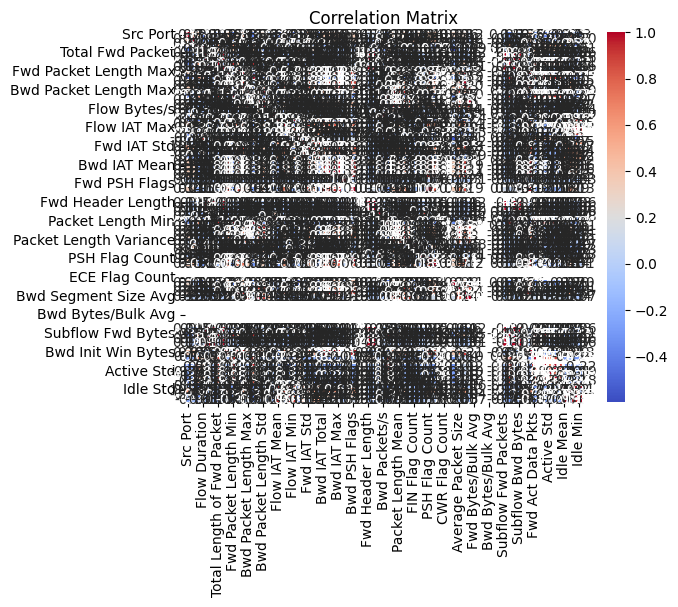

In [54]:
import seaborn as sns
sns.heatmap(df.select_dtypes(include=['number']).corr(),annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [55]:
#select columns based on coorelation matrix
correlation_matrix = df.select_dtypes(include=['number']).corr()
highly_correlated_features = set()  # Using a set to store unique features
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:  # Example threshold: 0.8
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

# 3. Remove highly correlated features from the DataFrame
filtered_df = df[[col for col in df.columns if col in highly_correlated_features]]
filtered_df.columns

Index(['Total Bwd packets', 'Total Length of Bwd Packet', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Min', 'Fwd IAT Std', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Std', 'PSH Flag Count', 'Average Packet Size', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Bwd Init Win Bytes', 'Fwd Act Data Pkts', 'Active Mean', 'Active Max', 'Idle Mean', 'Idle Max', 'Idle Min'], dtype='object')

In [56]:
print("Missing Values:")
print(df.isnull().sum())# no missing values


Missing Values:
Src Port         0
Dst Port         0
Protocol         0
Timestamp        0
Flow Duration    0
                ..
Idle Std         0
Idle Max         0
Idle Min         0
Activity         0
Stage            0
Length: 82, dtype: int64


In [57]:
#fill missing value of FlowByts/s
df['Flow Bytes/s'].fillna(df['Flow Bytes/s'].mean(), inplace=True)

<ipython-input-57-41a272957cbb>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Flow Bytes/s'].fillna(df['Flow Bytes/s'].mean(), inplace=True)


In [58]:
def find_outliers(df):
    """
    this is to find ouliers in the database

    """

    outlier = {}  # Store outlier indices for each column

    for column in df.select_dtypes(include=['number']):  # Iterate through numerical columns
        Q1 = df[column].quantile(0.25)  # Calculate the first quartile (25th percentile)
        Q3 = df[column].quantile(0.75)  # Calculate the third quartile (75th percentile)
        IQR = Q3 - Q1  # Calculate the Interquartile Range
    return outlier
find_outliers(df)
#we dont have any outliers in data

{}

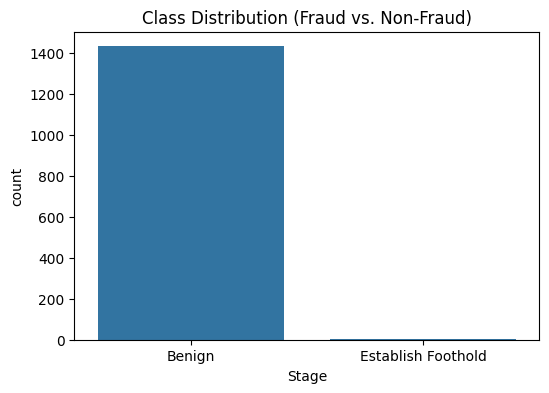

In [59]:
# Visualizing class distribution
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(x='Stage', data=df)
plt.title("Class Distribution (Fraud vs. Non-Fraud)")
plt.show()

In [60]:
nominal_cols = ['Activity']
# Use pd.get_dummies for One-Hot Encoding
df = pd.get_dummies(df, columns=nominal_cols, prefix=nominal_cols)


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1437 entries, 0 to 1436
Data columns (total 84 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Src Port                       1437 non-null   int64  
 1   Dst Port                       1437 non-null   int64  
 2   Protocol                       1437 non-null   int64  
 3   Timestamp                      1437 non-null   object 
 4   Flow Duration                  1437 non-null   int64  
 5   Total Fwd Packet               1437 non-null   int64  
 6   Total Bwd packets              1437 non-null   int64  
 7   Total Length of Fwd Packet     1437 non-null   float64
 8   Total Length of Bwd Packet     1437 non-null   float64
 9   Fwd Packet Length Max          1437 non-null   float64
 10  Fwd Packet Length Min          1437 non-null   float64
 11  Fwd Packet Length Mean         1437 non-null   float64
 12  Fwd Packet Length Std          1437 non-null   f

In [62]:
X = df.drop(columns=['Stage','Timestamp'])
y = df['Stage']
#convert values of df['Label] to 0 and 1
y = y.map({'Benign': 0, 'Establish Foothold': 1}).values

In [63]:
#data is heavly skewed towards non fradualent so we need to balalnce
#it before using in a model. will use SMOTE to balance it
from imblearn.over_sampling import SMOTE
from collections import Counter
smote=SMOTE(sampling_strategy=0.99,k_neighbors=2)
X,y=smote.fit_resample(X,y)
print(Counter(y))

Counter({np.int64(0): 1433, np.int64(1): 1418})


In [64]:

X.drop(columns=[c for c in X.columns if c.startswith('Unnamed')], inplace=True)



In [65]:

from sklearn.preprocessing import StandardScaler, LabelEncoder,OrdinalEncoder
print(X,y)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

      Src Port  Dst Port  Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  Total Length of Fwd Packet  Total Length of Bwd Packet  Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max   Flow IAT Min  Fwd IAT Total  Fwd IAT Mean   Fwd IAT Std   Fwd IAT Max    Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean   Bwd IAT Std   Bwd IAT Max  Bwd IAT Min  Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  Bwd URG Flags  Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  Packet Length Min  Packet Length Max  Packet Length Mean  Packet Length Std  Packet Length Variance  FIN Flag Count  SYN Flag Count  RST Flag Count  PSH Flag Count  ACK Flag Count  URG Flag Count  CWR Flag Count  ECE Flag Count  Down/Up Ratio  Average Packet Size  Fwd Segment Size Avg  Bwd Segment Size Avg  \
0

In [66]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2280, 82) (571, 82) (2280,) (571,)


` This code snippet uses a CNN as a feature extractor to create a lower-dimensional representation of the input data, which is likely intended to be further processed by a quantum algorithm or model.`






In [67]:
# cnn_input = Input(shape=(X_train.shape[1], 1))
# # cnn_input = Input(shape=input_shape)
# x = Conv1D(32, kernel_size=3, activation='relu')(cnn_input)
# x = MaxPooling1D(pool_size=2)(x)
# x = Flatten()(x)
# cnn_encoded = Dense(6, activation='relu')(x)  # Output 6 features for quantum

# cnn_model = Model(inputs=cnn_input, outputs=cnn_encoded)
# cnn_model.compile(optimizer='adam', loss='mse')

# # Reshape input for CNN (to have 3 dimensions)
# X_train_reshaped = X_train.reshape(-1, X_train.shape[1], 1)
# X_test_reshaped = X_test.reshape(-1, X_test.shape[1], 1)

# # Train using the CNN's own predictions as targets (unsupervised-like)
# cnn_model.fit(X_train_reshaped, cnn_model.predict(X_train_reshaped), epochs=32, batch_size=15, verbose=0)

# # Extract compressed features
# X_train_cnn = cnn_model.predict(X_train_reshaped)
# X_test_cnn = cnn_model.predict(X_test_reshaped)

`**Building a Hybrid Quantum LSTM Cell**`

`This code defines a function called hybrid_qlstm_cell_fixed that builds a quantum circuit inspired by the structure of a Long Short-Term Memory (LSTM) cell, a popular type of recurrent neural network used in classical machine learning. This circuit is designed to be used as a layer or component within a larger hybrid quantum-classical machine learning mode.This is likely to be integrated into a larger machine learning model where it will process data encoded in quantum states and learn patterns through the adjustment of its parameters during training.`

In [68]:
# Re-execute after kernel reset

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import ParameterVector

def hybrid_qlstm_cell_fixed(input_size, hidden_size):
    """
    Hybrid QLSTM-inspired quantum circuit with corrected parameter matching.
    This function avoids parameter mismatch error by ensuring:
    - Total circuit parameters = len(input_params) + len(weight_params)
    - Correct assignment of parameters in the circuit
    """

    num_qubits = input_size + 2 * hidden_size
    num_input_params = input_size  # for input encoding
    num_weight_params = num_qubits  # for rotation weights after entanglement

    # Declare parameter vectors
    input_params = ParameterVector('x', num_input_params)
    weight_params = ParameterVector('θ', num_weight_params)

    # Create circuit
    qr = QuantumRegister(num_qubits, 'q')
    qc = QuantumCircuit(qr, name="QLSTM_Cell")

    # Input encoding layer using Ry gates
    for i in range(input_size):
        qc.ry(input_params[i], qr[i])

    # Hidden state Ry encoding layer (initialize later half qubits)
    for i in range(hidden_size):
        qc.ry(input_params[i % num_input_params], qr[input_size + i])

    # Entanglement layer
    for i in range(num_qubits - 1):
        qc.cx(qr[i], qr[i+1])
        qc.rz(weight_params[i], qr[i+1])

    # Additional Ry encoding for output interpretation (can be adjusted)
    for i in range(hidden_size):
        qc.ry(weight_params[num_qubits - 1 - i], qr[num_qubits - 1 - i])

    return qc, input_params, weight_params

# Generate corrected circuit
qc, input_params_fixed, weight_params_fixed = hybrid_qlstm_cell_fixed(input_size=10, hidden_size=1)

# Visualize circuit
# circuit_fixed.draw('mpl')

In [69]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import classification_report
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten
# from tensorflow.keras.models import Model

# from qiskit import QuantumCircuit
# from qiskit.circuit import ParameterVector
# from qiskit.primitives import Estimator
# from qiskit_machine_learning.neural_networks import EstimatorQNN
# # from qiskit.algorithms.optimizers import COBYLA
# estimator = Estimator()
# qnn = EstimatorQNN(
#     circuit=qc,
#     input_params=input_params_fixed,
#     weight_params=weight_params_fixed,
#     estimator=estimator
# )

# # Convert training input to proper list of list format

# X_train_list = [[float(val) for val in list(row)] for row in X_train_cnn.tolist()]
# X_test_list = [[float(val) for val in list(row)] for row in X_test_cnn.tolist()]
# print("**********************",X_train_list[0])

# # Define loss function manually
# def loss_fn(weights):
#     weights = list(map(float, weights))  # ensure float format
#     preds = qnn.forward(X_train_list, weights)
#     preds = 1 / (1 + np.exp(-preds))  # sigmoid
#     y_true = y_train.reshape(-1, 1)
#     loss = -np.mean(y_true * np.log(preds + 1e-8) + (1 - y_true) * np.log(1 - preds + 1e-8))
#     return loss

# opt = SPSA(maxiter=200)

# x0 = [float(v) for v in np.random.rand(qnn.num_weights)]
# result = opt.minimize(loss_fn, x0=x0)

# # Inference
# weights_final = list(map(float, result.x))
# preds_test = qnn.forward(X_test_list, weights_final)
# y_pred = (1 / (1 + np.exp(-preds_test)) > 0.5).astype(int)

# print("Classification Report:")
# print(classification_report(y_test, y_pred))


In [70]:
# y_pred = (1 / (1 + np.exp(-preds_test)) > 0.51).astype(int)

# print("Classification Report:")
# print(classification_report(y_test, y_pred))

In [71]:
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve,roc_auc_score,ConfusionMatrixDisplay

# roc_auc = roc_auc_score(y_test, y_pred)
# print("ROC AUC Score:", roc_auc)
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# print(fpr, tpr, thresholds)
# #plot ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

In [72]:
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(10, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

sae_model = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

sae_model.compile(optimizer='adam', loss='mse')
sae_model.fit(X_train, X_train, epochs=50, batch_size=16, verbose=0)

X_train_sae = encoder.predict(X_train)
X_test_sae = encoder.predict(X_test)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [74]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
# from qiskit.algorithms.optimizers import COBYLA
estimator = Estimator()
qnn = EstimatorQNN(
    circuit=qc,
    input_params=input_params_fixed,
    weight_params=weight_params_fixed,
    estimator=estimator
)

# Convert training input to proper list of list format

X_train_list = [[float(val) for val in list(row)] for row in X_train_sae.tolist()]
X_test_list = [[float(val) for val in list(row)] for row in X_test_sae.tolist()]
print("**********************",X_train_list[0])

# Define loss function manually
def loss_fn(weights):
    weights = list(map(float, weights))  # ensure float format
    preds = qnn.forward(X_train_list, weights)
    preds = 1 / (1 + np.exp(-preds))  # sigmoid
    y_true = y_train.reshape(-1, 1)
    loss = -np.mean(y_true * np.log(preds + 1e-8) + (1 - y_true) * np.log(1 - preds + 1e-8))
    return loss

opt = SPSA(maxiter=200)

x0 = [float(v) for v in np.random.rand(qnn.num_weights)]
result = opt.minimize(loss_fn, x0=x0)

# Inference
weights_final = list(map(float, result.x))
preds_test_sae = qnn.forward(X_test_list, weights_final)
y_pred_sae = (1 / (1 + np.exp(-preds_test_sae)) > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_sae))


<ipython-input-74-9437af4e4258>:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
<ipython-input-74-9437af4e4258>:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


********************** [3.1544713973999023, 2.2175309658050537, 6.999276161193848, 5.926261901855469, 8.136972427368164, 0.0, 7.468784809112549, 0.0, 14.283571243286133, 0.0]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.46      0.63       291
           1       0.64      1.00      0.78       280

    accuracy                           0.73       571
   macro avg       0.82      0.73      0.71       571
weighted avg       0.82      0.73      0.71       571



In [95]:
y_pred_sae = (1 / (1 + np.exp(-preds_test_sae)) > 0.66).astype(int)

print("Classification Report for SAE:")
print(classification_report(y_test, y_pred_sae))

Classification Report for SAE:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       291
           1       0.86      0.75      0.80       280

    accuracy                           0.82       571
   macro avg       0.82      0.81      0.81       571
weighted avg       0.82      0.82      0.82       571



ROC AUC Score: 0.8148625429553263
[0.         0.12027491 1.        ] [0.   0.75 1.  ] [inf  1.  0.]


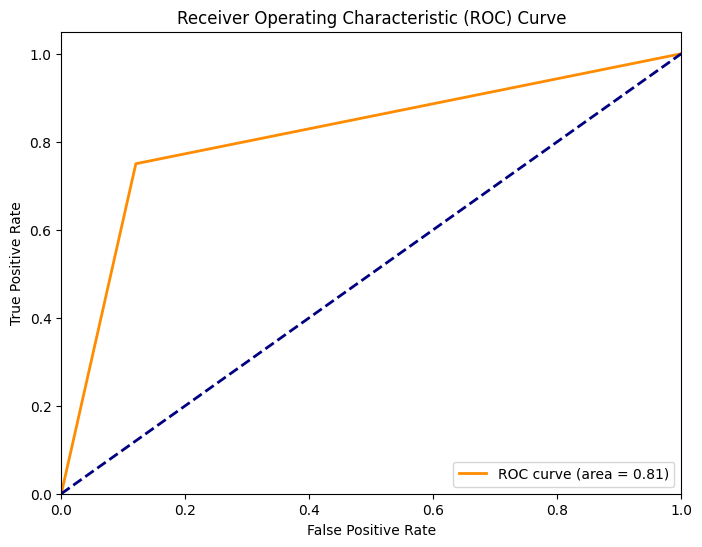

In [96]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve,roc_auc_score,ConfusionMatrixDisplay

roc_auc = roc_auc_score(y_test, y_pred_sae)
print("ROC AUC Score:", roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_sae)
print(fpr, tpr, thresholds)
#plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()